## Check GPU status

In [1]:
from utils import check_gpu_status

check_gpu_status()

Num GPUs Available: 1
1 Physical GPU(s), 1 Logical GPU(s)


## Data Preparation



In [2]:
import os
from custom_datagen import DataGenerator

batch_size = 16 # If the GPU memory allows, try to use bigger batch size
num_classes = 5
channels = {'R': 0, 'G': 1, 'B': 2, 'NIR': 3}

# Define the root directory
root_dir = r"F:\DEEP_LEARNING_GIS"
# data_dir = os.path.join(root_dir, "2019_Holdout")
data_dir = os.path.join(root_dir, "LandCover_Holdout")
# Train Dataset
train_imgs = os.path.join(data_dir, "train", "images")
train_masks = os.path.join(data_dir, "train", "masks")

# Validation Dataset
val_imgs = os.path.join(data_dir, "val", "images")
val_masks = os.path.join(data_dir, "val", "masks")

# Define paths to output models and logs
model_name = "UNet_LandCover_v1.hdf5"
name_parts = model_name.split('.')
logfile_name = f"{name_parts[0]}_logs.csv"

model_path = os.path.join(root_dir, "Trained_Models", model_name)
log_path = os.path.join(root_dir, "Logs", logfile_name)

# Create directories if they do not exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(log_path), exist_ok=True)

print(f"Model will be saved to: {model_path}")
print(f"Logs will be saved to: {log_path}")


Model will be saved to: F:\DEEP_LEARNING_GIS\Trained_Models\UNet_LandCover_v1.hdf5
Logs will be saved to: F:\DEEP_LEARNING_GIS\Logs\UNet_LandCover_v1_logs.csv


## Initialize Data Generators


In [3]:
# Initialize data generators
train_gen = DataGenerator(
    img_dir=train_imgs,
    mask_dir=train_masks,
    batch_size=batch_size,
    n_classes=num_classes,
    image_shape=(512,512),
    image_aug=True,
    index_shuffle=True,
    channel_shuffle=False,
    calculate_pisi=True,
    calculate_ndvi=True,
    k_fold_indices=None,
    img_extension='.TIF',
    channels=None
)

val_gen = DataGenerator(
    img_dir=val_imgs,
    mask_dir=val_masks,
    batch_size=batch_size,
    n_classes=num_classes,
    image_shape=(512,512),
    image_aug=False,
    index_shuffle=False,
    channel_shuffle=False,
    calculate_pisi=True,
    calculate_ndvi=True,
    k_fold_indices=None,
    img_extension='.TIF',
    channels=None
)


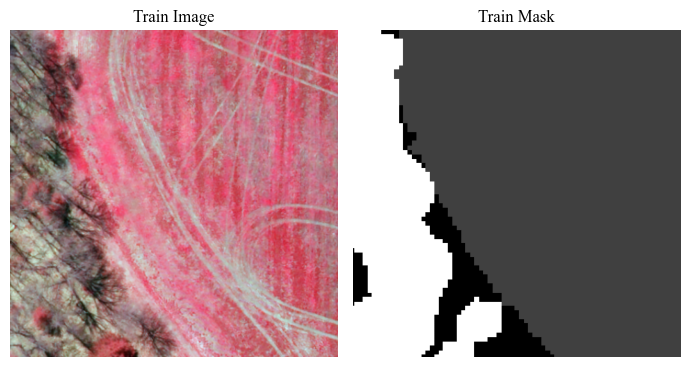

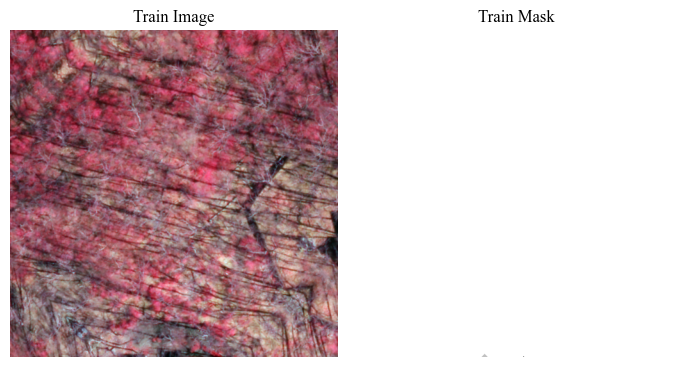

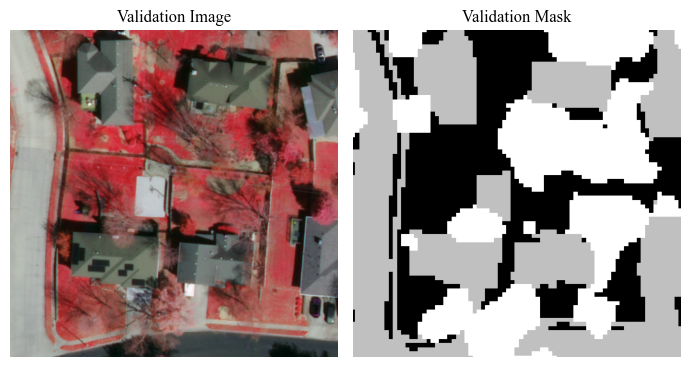

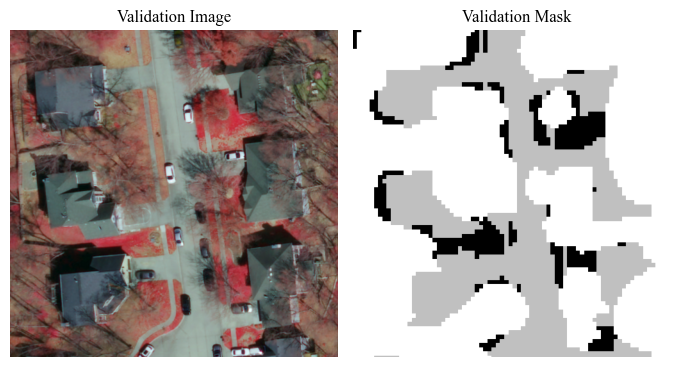

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve next batches
train_img, train_msk = train_gen.generator.__next__()
val_img, val_msk = val_gen.generator.__next__()

# Visualize random images and masks from training and validation batches
datasets = [(train_img, train_msk, "Train"), 
            (val_img, val_msk, "Validation")]

plt.rcParams['font.family'] = 'Times New Roman'
for images, masks, prefix in datasets:
    # Randomly select 2 indices from the batch
    random_indices = np.random.choice(images.shape[0], 2, replace=False)
    for i in random_indices:
        plt.figure(figsize=(7, 5))
        
        # Display Image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i][:,:,[3,0,1]], cmap='gray') # [3,0,1]: False color 
        plt.title(f"{prefix} Image")
        plt.axis('off')
        
        # Display Mask
        plt.subplot(1, 2, 2)
        if num_classes > 1:
            mask = np.argmax(masks[i], axis=-1)
        else:
            mask = masks[i]
        plt.imshow(mask, cmap='gray')
        plt.title(f"{prefix} Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        

In [5]:
import os
# import losses_metrics
from keras.optimizers import Adam
from keras.models import load_model
from models import get_model # Models can be imported indivually from models.py
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import segmentation_models as sm

# Initialize the parameters
input_shape = (512, 512, 6)
optimizer = Adam(learning_rate=1e-3)

# Loss and Metrics to track
loss = sm.losses.dice_loss
metrics = [sm.metrics.iou_score]

#Keras Callbacks
checkpoint = ModelCheckpoint(model_path, monitor = 'val_iou_score', 
                             verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='loss', patience=30, verbose=1)
log_csv = CSVLogger(log_path, separator=',', append=False)

# List to store the Callbacks
callbacks_list = [checkpoint, 
                  early_stop, 
                  log_csv]


Segmentation Models: using `keras` framework.


In [9]:
# Compile the model
model = get_model("resunet", 
                  input_shape, 
                  filter_list=[16, 32, 64, 128, 256], 
                  num_conv_stack = 3,
                  batch_norm = True,
                  downsample_type = 'maxpool',
                  upsample_type = 'deconv',
                  bottleneck_type='conv',
                  # atrous_rates = [1, 2, 4, 6],
                  num_classes = num_classes,
                  output_activation = 'softmax'
                  )

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "resunet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_99 (Conv2D)             (None, 512, 512, 16  880         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_113 (Batch  (None, 512, 512, 16  64         ['conv2d_99[0][0]']              
 Normalization)                 )                                                           

In [ ]:
# # Continue the training by loading the saved weights
# # Define the path to your model and the custom objects needed for loading
# model_name = "UNet_LandCover.hdf5"
# model_path = os.path.join(root_dir, "Trained_Models", model_name)

# custom_objects = {
#     'dice_loss': sm.losses.dice_loss,
#     'iou_score': sm.metrics.iou_score,
# }

# # Load the original model with custom loss and metrics
# model = load_model(model_path, custom_objects=custom_objects)
# model.summary()

In [ ]:
# Define the steps per epoch
train_steps_per_epoch = len(train_gen.img_list) // batch_size
val_steps_per_epoch = len(val_gen.img_list) // batch_size

# Fit the model
model.fit(
    train_gen.generator, 
    verbose=1, 
    epochs=200, 
    validation_data=val_gen.generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks_list
) 


In [ ]:
# model.save(os.path.join(root_dir, "Saved_Models", f"final_{model_name}"))

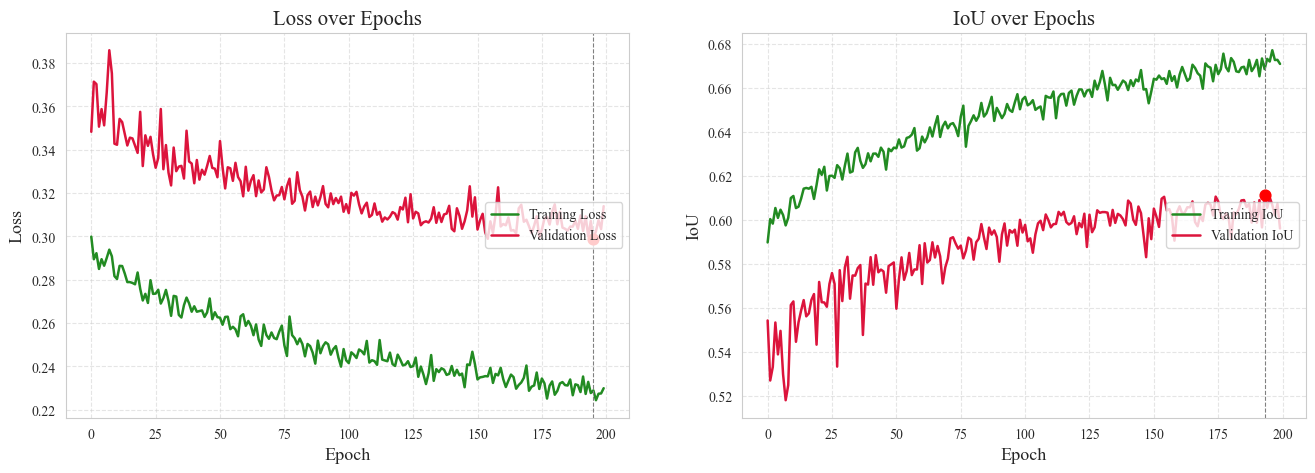

In [10]:
import pandas as pd
from utils import plot_loss_and_metric  

data = pd.read_csv(log_path)


best_iou = data['val_iou_score'].idxmax()
best_loss = data['val_loss'].idxmin()


plot_loss_and_metric(data, 'epoch', 'loss', 'val_loss', 'iou_score', 'val_iou_score', best_iou, best_loss)


In [11]:
from utils import load_test_datasets

# Test dataset
test_imgs_path = os.path.join(data_dir, "test", "images")
test_masks_path = os.path.join(data_dir, "test", "masks")
test_imgs, test_masks = load_test_datasets(test_imgs_path, test_masks_path, calculate_pisi=True, 
                                           calculate_ndvi=True, img_extension='.TIF', channels=channels)

Processing Masks: 100%|██████████| 2120/2120 [00:06<00:00, 338.49it/s]


## Step 4.2: Predicting Test Images

Predicting the test images involves using the trained model to generate segmentation masks for the test dataset. This process evaluates how well the model can generalize to new, unseen data.


In [12]:
from utils import predict_test_images

model_name = "UNet_LandCover_v1.hdf5"
model_path = os.path.join(root_dir, "Trained_Models", model_name)

predictions = predict_test_images(test_imgs, model_path, num_classes=num_classes, 
                                  threshold=None, augment_test=False, pred_type='argmax')

Predicting: 100%|██████████| 2120/2120 [05:32<00:00,  6.37it/s]


## Step 4.3: Calculating Metrics and Confusion Matrix


In [13]:
from utils import calculate_metrics_multiclass

num_classes = 5
metrics, conf_matrix = calculate_metrics_multiclass(test_masks, predictions, num_classes)

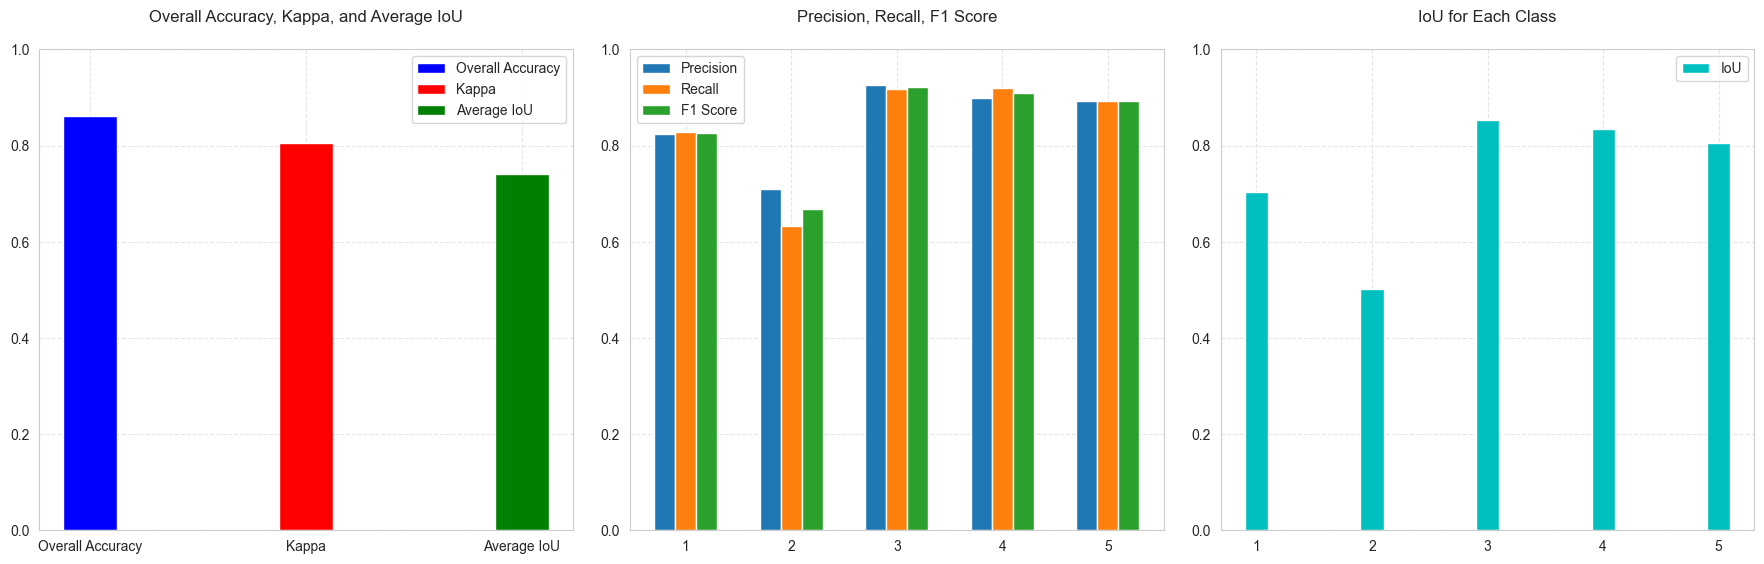

In [14]:
from utils import plot_metrics_multi

class_labels = ['Class 1', ' Class 2', 'Class 3', 'Class 4', 'Class 5']
plot_metrics_multi(metrics, class_labels)

### Plotting the normalized confusion matrix

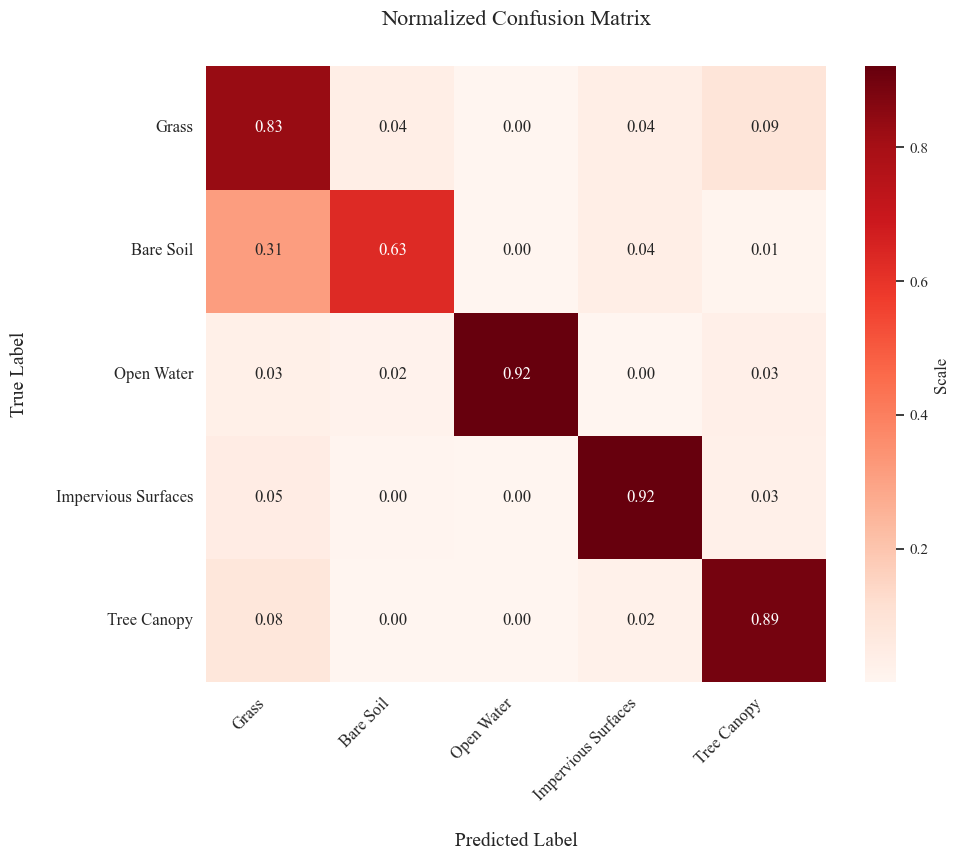

In [15]:
from utils import plot_conf_matrix_multi

class_labels = ['Grass', 'Bare Soil', 'Open Water', 'Impervious Surfaces', 'Tree Canopy']
plot_conf_matrix_multi(conf_matrix, class_labels, normalize=True)

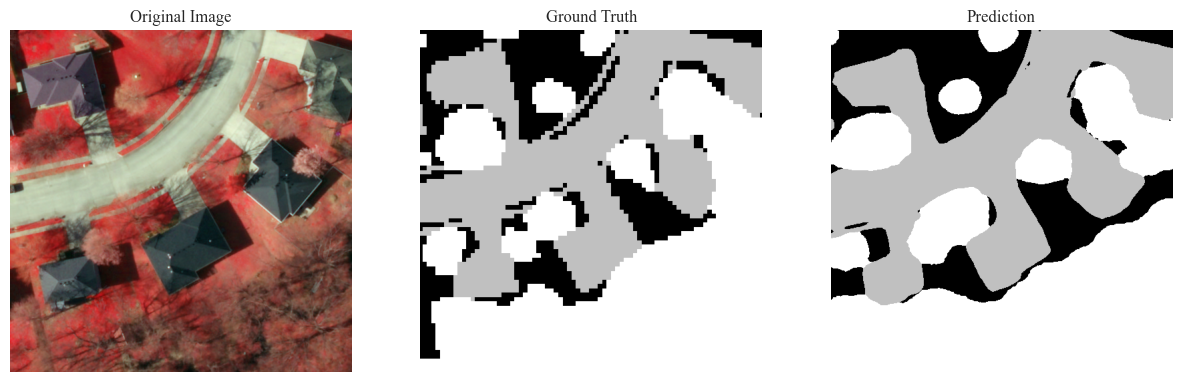

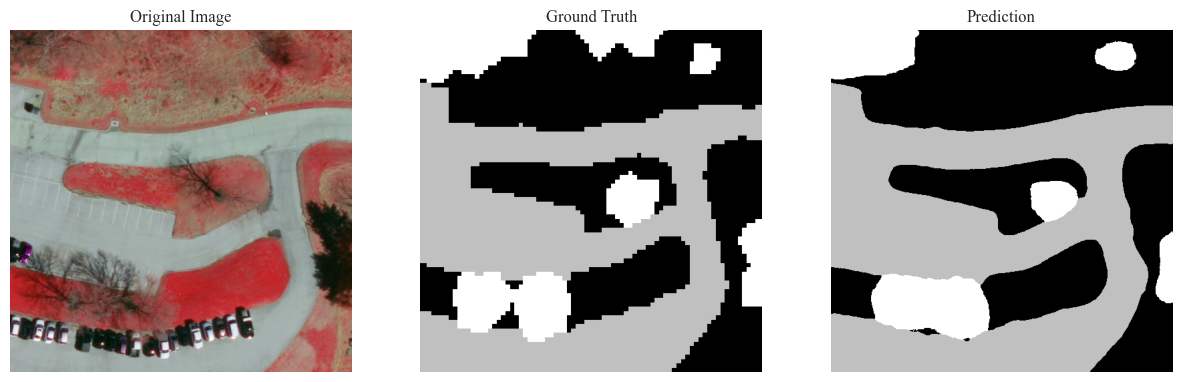

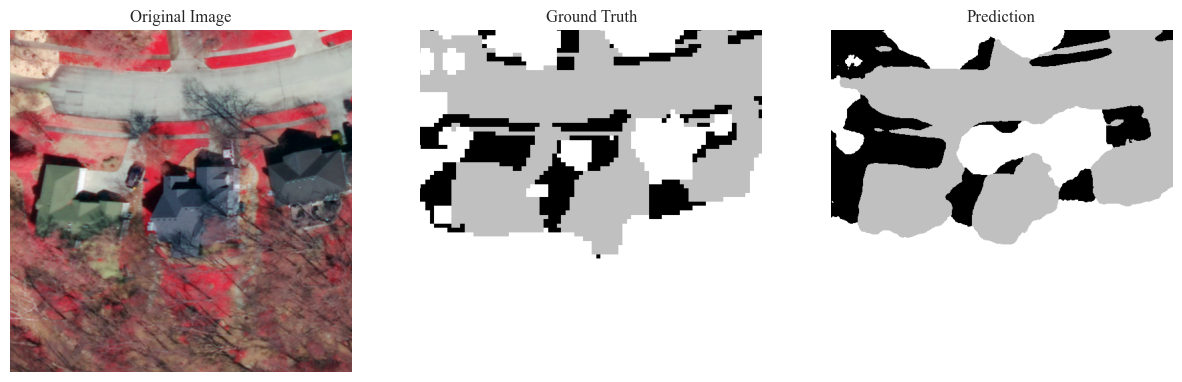

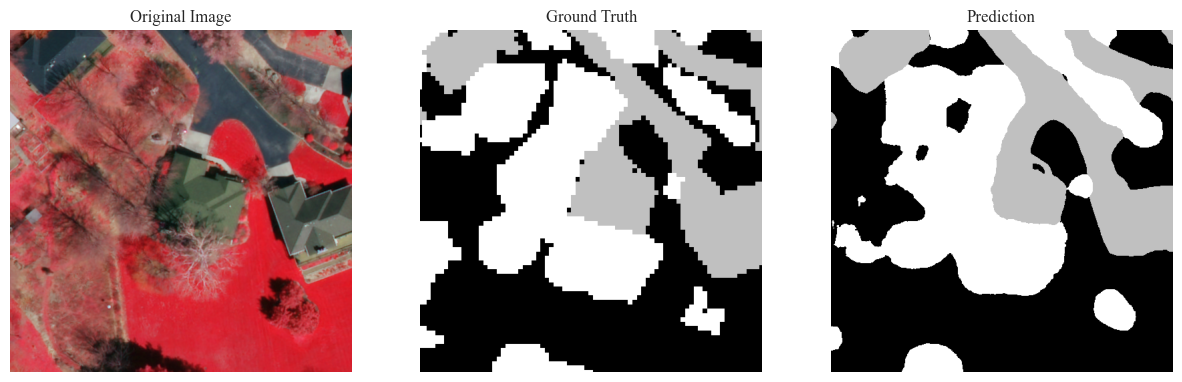

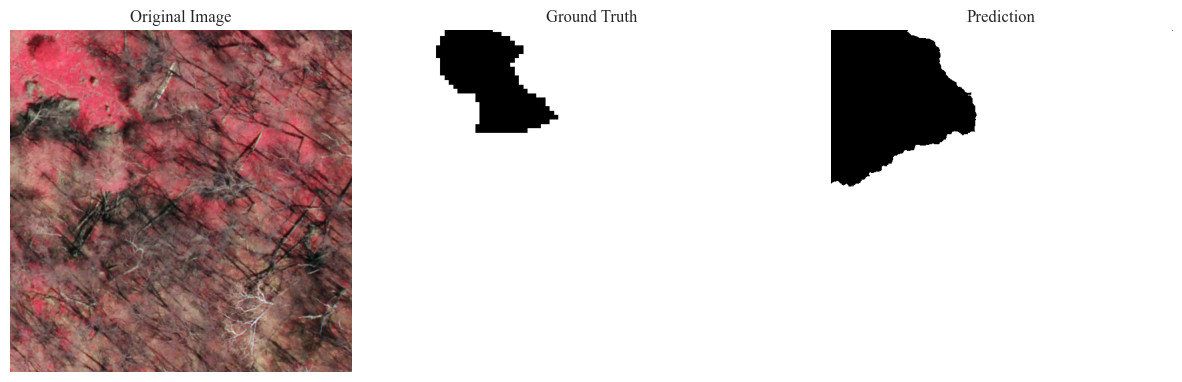

In [41]:
# Visualize a few random examples
num_examples_to_visualize = 5
random_indices = np.random.choice(
    len(test_imgs), num_examples_to_visualize, replace=False
)

plt.rcParams['font.family'] = 'Times New Roman'
for index in random_indices:
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_imgs[index][:,:,[3,0,1]])
    plt.title('Original Image')
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


---

### Created by:  
**Anar Batmunkh**  
*Geography, MA*  
*University of Missouri, 2024*

---
